# <font color='#8735fb'> **RAPIDS Multi-GPU Workflow - XGBoost @ Airline Delays** </font> 

<img src='https://raw.githubusercontent.com/rapidsai/cloud-ml-examples/main/aws/img/airline_dataset.png' width='1250px'>

> **1. Mount S3 Dataset**

> **2. Data Ingestion**

> **3. ETL**
-> handle missing -> split

> **4. Train Classifier**
-> XGBoost

> **5. Inference**
-> FIL

In [1]:
from dask.distributed import Client, LocalCluster, wait
from dask_cuda import LocalCUDACluster
import dask_cudf
import dask

from dask_ml.model_selection import train_test_split
from cuml.dask.common.utils import persist_across_workers

import xgboost
from cuml.metrics import accuracy_score
from cuml import ForestInference
import glob

### <font color='#8735fb'> **Mount S3 Dataset** </font>

Optional: Attach a s3 bucket to the local filesystem

### <font color='#8735fb'> **Create Cluster** </font>

In [2]:
cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39503 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.19 GB


### <font color='#8735fb'> **Ingest Parquet Data** </font>

At the heart of our analysis will be domestic carrier on-time reporting data that has been kept for decades by the U.S. Bureau of Transportation.

This rich source of data allows us to scale, so while in this notebook (ML_100.ipynb) we only use 1 GPU and 1 year of data, in the next notebook (ML200.ipynb) we'll use 10 years of data and multiple GPUs.

> **Dataset**: [US.DoT - Reporting Carrier On-Time Performance, 1987-Present](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236)

The public dataset contains logs/features about flights in the United States (17 airlines) including:

* locations and distance  ( `Origin`, `Dest`, `Distance` )
* airline / carrier ( `Reporting_Airline` )
* scheduled departure and arrival times ( `CRSDepTime` and `CRSArrTime` )
* actual departure and arrival times ( `DpTime` and `ArrTime` )
* difference between scheduled & actual times ( `ArrDelay` and `DepDelay` )
* binary encoded version of late, aka our target variable ( `ArrDelay15` )

In [3]:
airline_feature_columns = [ 'Year', 'Quarter', 'Month', 'DayOfWeek', 
                            'Flight_Number_Reporting_Airline', 'DOT_ID_Reporting_Airline',
                            'OriginCityMarketID', 'DestCityMarketID',
                            'DepTime', 'DepDelay', 'DepDel15', 'ArrDel15',
                            'AirTime', 'Distance' ]
airline_label_column = 'ArrDel15'

In [4]:
glob.glob( 'data/3_year/*.parquet' )

['data/3_year/part.0.parquet',
 'data/3_year/part.1.parquet',
 'data/3_year/part.10.parquet',
 'data/3_year/part.11.parquet',
 'data/3_year/part.12.parquet',
 'data/3_year/part.13.parquet',
 'data/3_year/part.14.parquet',
 'data/3_year/part.15.parquet',
 'data/3_year/part.16.parquet',
 'data/3_year/part.17.parquet',
 'data/3_year/part.18.parquet',
 'data/3_year/part.19.parquet',
 'data/3_year/part.2.parquet',
 'data/3_year/part.20.parquet',
 'data/3_year/part.21.parquet',
 'data/3_year/part.22.parquet',
 'data/3_year/part.23.parquet',
 'data/3_year/part.24.parquet',
 'data/3_year/part.25.parquet',
 'data/3_year/part.26.parquet',
 'data/3_year/part.27.parquet',
 'data/3_year/part.28.parquet',
 'data/3_year/part.29.parquet',
 'data/3_year/part.3.parquet',
 'data/3_year/part.30.parquet',
 'data/3_year/part.31.parquet',
 'data/3_year/part.32.parquet',
 'data/3_year/part.33.parquet',
 'data/3_year/part.34.parquet',
 'data/3_year/part.35.parquet',
 'data/3_year/part.36.parquet',
 'data/3_yea

In [5]:
%%time
data = dask_cudf.read_parquet( "data/3_year/*.parquet", 
                               columns = airline_feature_columns)

CPU times: user 1.18 s, sys: 512 ms, total: 1.69 s
Wall time: 2.25 s


In [6]:
data

,Year,Quarter,Month,DayOfWeek,Flight_Number_Reporting_Airline,DOT_ID_Reporting_Airline,OriginCityMarketID,DestCityMarketID,DepTime,DepDelay,DepDel15,ArrDel15,AirTime,Distance
npartitions=37,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### <font color='#8735fb'> **Handle Missing** </font>

In [7]:
%%time
data = data.dropna()

CPU times: user 148 ms, sys: 9.8 ms, total: 158 ms
Wall time: 143 ms


### <font color='#8735fb'> **Split** </font>

In [8]:
label_column = airline_label_column

train, test = train_test_split( data, random_state = 0 ) 

# build X [ features ], y [ labels ] for the train and test subsets
y_train = train[label_column]; 
X_train = train.drop(label_column, axis = 1)
y_test = test[label_column]
X_test = test.drop(label_column, axis = 1)

/opt/conda/envs/rapids/lib/python3.8/site-packages/dask_ml/model_selection/_split.py:462: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [9]:
X_train

,Year,Quarter,Month,DayOfWeek,Flight_Number_Reporting_Airline,DOT_ID_Reporting_Airline,OriginCityMarketID,DestCityMarketID,DepTime,DepDelay,DepDel15,AirTime,Distance
npartitions=37,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


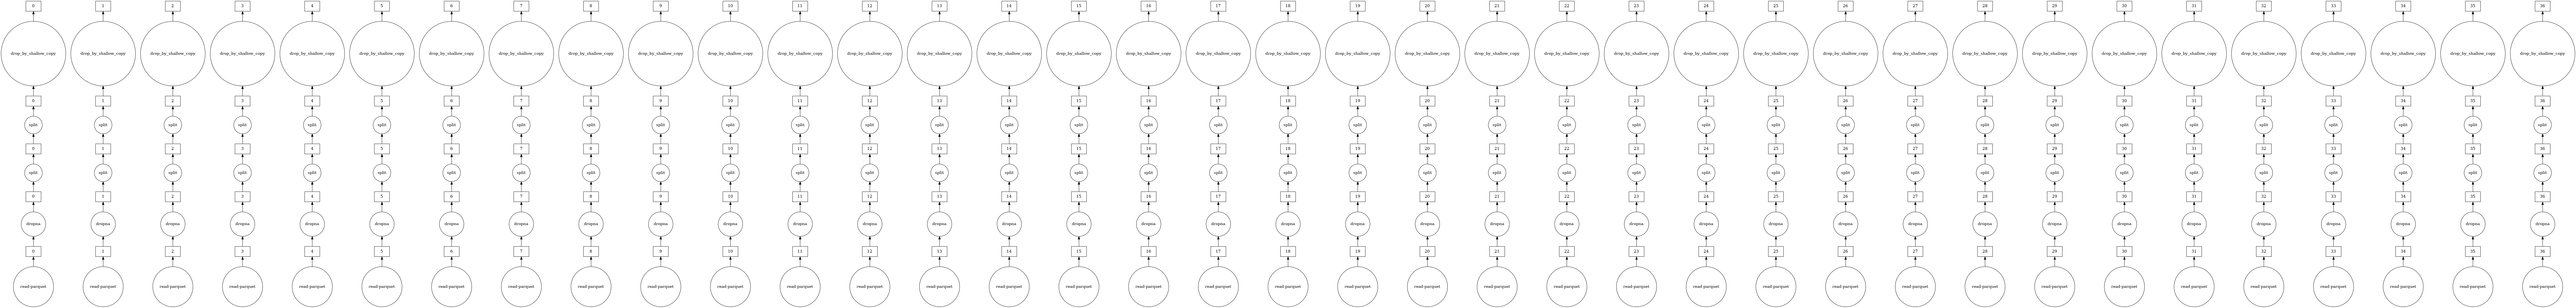

In [10]:
X_train.visualize()

### <font color='#8735fb'> **Persist** </font>

In [11]:
# force execution
X_train, y_train, X_test, y_test = persist_across_workers( client,
                                                           [ X_train, y_train, X_test, y_test ], 
                                                           workers = client.has_what().keys() )
wait([X_train, y_train, X_test, y_test]);

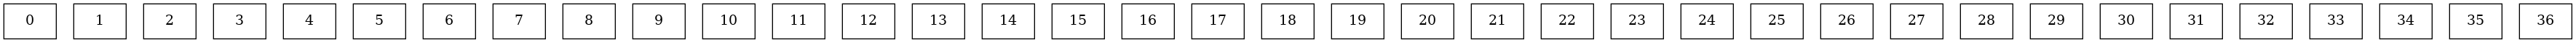

In [22]:
X_train.visualize()

### <font color='#8735fb'> **Train/Fit** </font>

In [12]:
model_params = {            
    'max_depth' : 10,
    'num_boost_round': 300,
    'learning_rate': .25,
    'gamma': 0,
    'lambda': 1,
    'random_state' : 0,
    'verbosity' : 0,
    'seed': 0,   
    'objective' : 'binary:logistic',
    'tree_method': 'gpu_hist'
} 

In [13]:
%%time
dtrain = xgboost.dask.DaskDMatrix( client, X_train, y_train)
xgboost_output = xgboost.dask.train( client, model_params, dtrain, 
                                     num_boost_round = model_params['num_boost_round'] )
trained_model = xgboost_output['booster']

/opt/conda/envs/rapids/lib/python3.8/site-packages/distributed/client.py:3518: RuntimeWarning: coroutine 'Client._update_scheduler_info' was never awaited
  self.sync(self._update_scheduler_info)


CPU times: user 1.09 s, sys: 427 ms, total: 1.52 s
Wall time: 20.5 s


### <font color='#8735fb'> **Predict & Score** </font>

In [14]:
%%time
# ensure that the inference target data (X_test, y_test) is computed [i.e., concrete values in local memory ]
y_test_computed = y_test.compute()
X_test_computed = X_test.compute()

CPU times: user 259 ms, sys: 192 ms, total: 451 ms
Wall time: 461 ms


### <font color='#8735fb'> **XGBoost Native Predict & Score** </font>

In [16]:
threshold = 0.5
dtest = xgboost.dask.DaskDMatrix( client, X_test )

In [17]:
%%time
predictions = xgboost.dask.predict( client, trained_model, dtest).compute() 
predictions = (predictions > threshold ) * 1.0
score = accuracy_score ( y_test_computed.astype('float32'),
                         predictions.astype('float32') )

print(f'score = {score}')

score = 0.9347475171089172
CPU times: user 427 ms, sys: 98.5 ms, total: 525 ms
Wall time: 1.4 s


In [18]:
model_filename = 'trained-model.xgb'
trained_model.save_model( model_filename )

### <font color='#8735fb'> **ForestInference Predict & Score** </font>

In [19]:
reloaded_model = ForestInference.load( model_filename )

In [21]:
%%time 
fil_predictions = reloaded_model.predict( X_test_computed )
fil_predictions = ( fil_predictions > threshold ) * 1.0
score = accuracy_score ( y_test_computed.astype('float32'),
                         fil_predictions.astype('float32') )
print(f'fil score = {score}')

fil score = 0.9347475171089172
CPU times: user 101 ms, sys: 22.1 ms, total: 123 ms
Wall time: 120 ms


### <font color='#8735fb'> **Additional References** </font>